# Vehicle Detection and Tracking

---

In [171]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label as label_heatmap

import os
import time
import pickle

%matplotlib inline

## Load Data

In [144]:
test_images = [mpimg.imread('test_images/' + file) for file in os.listdir('test_images')]

In [3]:
# These are all 64x64 png images

vehicles_folders = ['data/vehicles/GTI_Far/', 'data/vehicles/GTI_Left/', 'data/vehicles/GTI_MiddleClose/', 'data/vehicles/GTI_Right/', 'data/vehicles/KITTI_extracted/']
nonvehicles_folders = ['data/non-vehicles/Extras/', 'data/non-vehicles/GTI/']

udacity_vehicles = [mpimg.imread(folder + file) for folder in vehicles_folders for file in os.listdir(folder)]
udacity_non_vehicles = [mpimg.imread(folder + file) for folder in nonvehicles_folders for file in os.listdir(folder)]

udacity_features_raw = np.concatenate((udacity_vehicles, udacity_non_vehicles))

## Train SVM

In [128]:
def feature_pipeline(image, feature_vector=True, resize=True, gamma=False):
    cells_per_block = (2,2)
    pixels_per_cell = (8,8)
    orientations= 7
    
    if resize:
        image = cv2.resize(image, (64, 64))
        
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    ch0 = yuv[:,:,0]
    ch1 = yuv[:,:,1]
    ch2 = yuv[:,:,2]
    ch0_features = hog(ch0, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector, transform_sqrt=gamma)
    ch1_features = hog(ch1, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector, transform_sqrt=gamma)
    ch2_features = hog(ch2, orientations, pixels_per_cell, cells_per_block, feature_vector=feature_vector, transform_sqrt=gamma)
    
    if feature_vector:
        hog_features = np.concatenate((ch0_features, ch1_features, ch2_features))
#     print(hog_features.shape)
    return hog_features

In [152]:
loadfile = True
filename = "pickles/{0}cpb_{1}ppc_{2}o_{3}_gamma.p".format(2,8,7,'yuv')

start = time.time()

if loadfile:
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    udacity_features_scaled = data['features']
    udacity_labels = data['labels']
    
else:
    udacity_features = [feature_pipeline(image) for image in udacity_features_raw]
    udacity_labels = np.concatenate((np.ones(len(udacity_vehicles)), np.zeros(len(udacity_non_vehicles))))

    scaler = StandardScaler()
    scaler.fit(udacity_features)
    udacity_features_scaled = scaler.transform(udacity_features)


    with open(filename, 'wb') as f:
        pickle.dump({'features': udacity_features_scaled, 'labels': udacity_labels }, f)

end = time.time()

print('Runtime (s):', end - start)

Runtime (s): 1.6283400058746338


In [153]:
start = time.time()

split_index = int(len(udacity_features_scaled) * .8)
X_train = udacity_features_scaled[0: split_index]
X_test = udacity_features_scaled[split_index:]
y_train = udacity_labels[0:split_index]
y_test = udacity_labels[split_index:]
# X_train, X_test, y_train, y_test = train_test_split(udacity_features_scaled, udacity_labels)

svc = LinearSVC(C=3e-7)
svc.fit(X_train, y_train)

train_accuracy = svc.score(X_train, y_train)
val_accuracy = svc.score(X_test, y_test)

end = time.time()

print('Train Accuracy: ', train_accuracy)
print('Val Accuracy: ', val_accuracy)
print('Model runtime (s):', end - start)

Train Accuracy:  0.957981418919
Val Accuracy:  0.953828828829
Model runtime (s): 6.514983177185059


## Pipeline

In [210]:
def pipeline(image):
    image = np.copy(image)
#     features = feature_pipeline(image, feature_vector=False, resize=True)
#     print(features.shape)
#     return image

    search_spaces = [(360, 720, 140, 30), (400, 600, 115, 30), (400, 550, 90, 30)]
    colors = [(255,0,0), (0,255,0), (0,0,255)]
    local_heatmap = np.zeros((720, 1280))
    
    for color, space in zip(colors, search_spaces):
        windows = sliding_windows(*space)
        window_images = [image[y1:y2,x1:x2][np.newaxis, ...] for x1,y1,x2,y2 in windows]
        window_images = np.concatenate(window_images, axis=0)
        features = [feature_pipeline(window_image, gamma=True)[np.newaxis,...] for window_image in window_images]
        features = np.concatenate(features)
    
        features_scaled = scaler.transform(features)
        pred = svc.predict(features_scaled)   
        
        for window, guess in zip(windows, pred):
            if guess == 1:
#                 cv2.rectangle(image, (window[0], window[1]), (window[2], window[3]), color, 5)
                local_heatmap[window[1]:window[3], window[0]:window[2]] += 1
    
    global heatmap
    heatmap = .5 * heatmap + .5* local_heatmap
    thresholded = heatmap > 1
    car_labels = label_heatmap(thresholded)
    for i in range(car_labels[1]):
        indexes = (car_labels[0] == i+1).nonzero()
        upperLeft = (np.min(indexes[1]), np.min(indexes[0]))
        lowerRight = (np.max(indexes[1]), np.max(indexes[0]))
        cv2.rectangle(image, upperLeft, lowerRight, (255, 0, 0), 5)
    
    return image
    

def sliding_windows(ystart, ystop, size, step, shape=(720, 1280)):
    xstart = 600
    return [(x,y, x+size, y+size) for y in range(ystart, ystop - size, step) for x in range(xstart, shape[1] - size, step)]

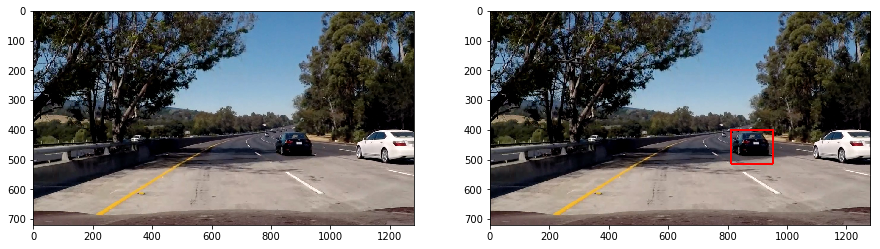

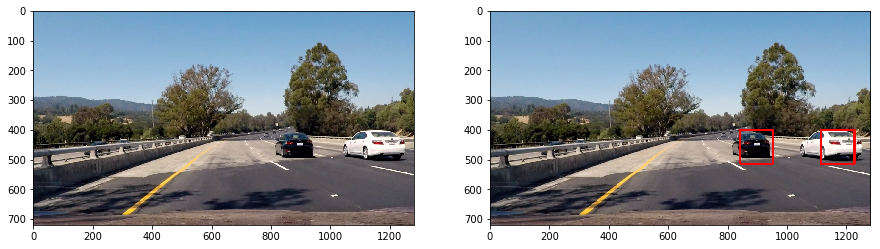

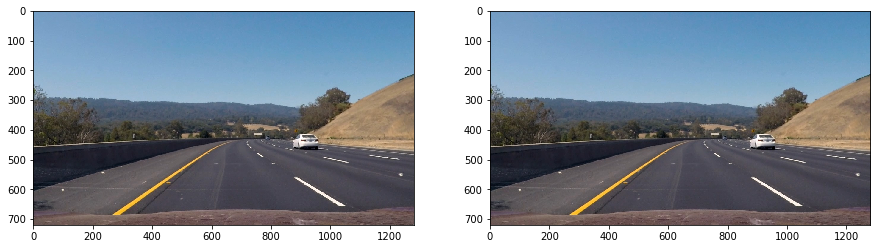

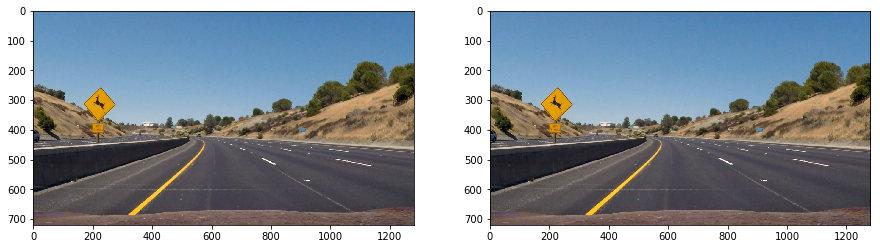

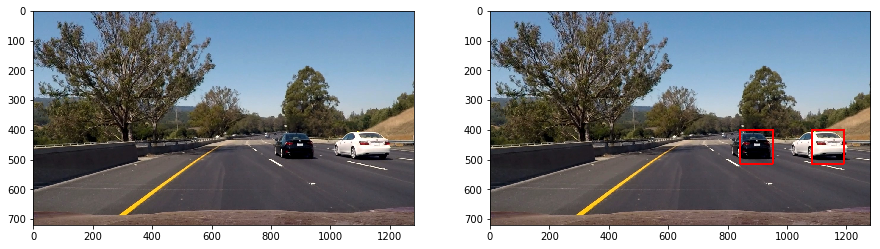

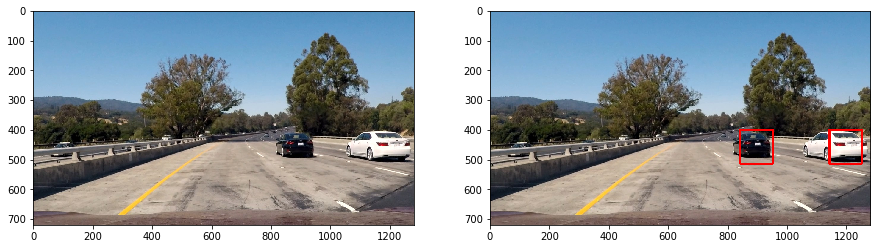

In [199]:
for image in test_images:
    heatmap = np.zeros((720, 1280))
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    processed = pipeline(image)
    plt.imshow(processed)
    break

## Video

In [213]:
heatmap = np.zeros((720, 1280))
clip = VideoFileClip('project_video.mp4')
processed_vid = clip.fl_image(pipeline)
%time processed_vid.write_videofile('processed_video.mp4', audio=False)

[MoviePy] >>>> Building video processed_video.mp4
[MoviePy] Writing video processed_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:04<1:25:03,  4.05s/it]

  0%|          | 2/1261 [00:08<1:25:34,  4.08s/it]

  0%|          | 3/1261 [00:12<1:26:02,  4.10s/it]

  0%|          | 4/1261 [00:16<1:26:25,  4.13s/it]

  0%|          | 5/1261 [00:20<1:26:35,  4.14s/it]

  0%|          | 6/1261 [00:24<1:26:20,  4.13s/it]

  1%|          | 7/1261 [00:28<1:26:21,  4.13s/it]

  1%|          | 8/1261 [00:33<1:26:11,  4.13s/it]

  1%|          | 9/1261 [00:37<1:25:55,  4.12s/it]

  1%|          | 10/1261 [00:41<1:25:46,  4.11s/it]

  1%|          | 11/1261 [00:45<1:25:57,  4.13s/it]

  1%|          | 12/1261 [00:49<1:26:37,  4.16s/it]

  1%|          | 13/1261 [00:54<1:28:38,  4.26s/it]

  1%|          | 14/1261 [00:58<1:28:22,  4.25s/it]

  1%|          | 15/1261 [01:02<1:28:04,  4.24s/it]

  1%|▏         | 16/1261 [01:06<1:27:51,  4.23s/it]

  1%|▏         | 17/1261 [01:11<1:28:36,  4.27s/it]

  1%|▏         | 18/1261 [01:15<1:28:04,  4.25s/it]

  2%|▏     

[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video.mp4 

CPU times: user 1h 31min 41s, sys: 35min 34s, total: 2h 7min 15s
Wall time: 1h 27min 37s


In [214]:
HTML("""
<video width="640" height= 360" controls>
  <source src="{0}">
</video>
""".format('processed_video.mp4'))